<a href="https://colab.research.google.com/github/samuelhernandez99/SpatialModelingTutorials/blob/main/Notebooks/CostaRica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install geemap

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


# Import packages

In [3]:
#import packages
import geopandas as gpd, pandas as pd, os, numpy as np
import ee, geemap

## Authenticate and Initialize the project

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-samh') #you will want to select your personal cloud project

# Read the shape file into a geodataframe
## Display CRS and column names

### If running on Colab you will need to upload the Clasification_Plot.zip file

In [5]:
gdf=gpd.read_file('/content/drive/MyDrive/work_stuff/Clasification_Plots.zip')
display(gdf.crs)
display(gdf.columns)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Index(['Source.Nam', 'plotid', 'sampleid', 'lon', 'lat', 'sample_geo', 'Uso',
       'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo',
       'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF', 'Cambios15_',
       'Gana_Perdi', 'geometry'],
      dtype='object')

## Subset the geodataframe to the columns we are interested in and display the dataframe

In [6]:
k_clms = ['plotid','sampleid','Vegetacion','Herbaceas', 'Pasto_Arb', 'Cultivo','Humedal', 'Terreno','Agua','Otra_clase','SAF','Cambios15_','Gana_Perdi','geometry']
gdf_s=gdf[k_clms]
gdf_s


,plotid,sampleid,Vegetacion,Herbaceas,Pasto_Arb,Cultivo,Humedal,Terreno,Agua,Otra_clase,SAF,Cambios15_,Gana_Perdi,geometry
0,2900,11597,Arboles,None,None,None,None,None,None,None,None,No se determina,None,POINT (-84.90887 10.87476)
1,2900,11598,Herbaceas,Gramineas,Pastos mezclados (70-90%),None,None,None,None,None,None,No se determina,None,POINT (-84.90887 10.87519)
2,2900,11599,Herbaceas,Gramineas,Pastos mezclados (70-90%),None,None,None,None,None,None,No se determina,None,POINT (-84.90887 10.87561)
3,2900,11600,Arboles,None,None,None,None,None,None,None,None,No se determina,None,POINT (-84.90844 10.87476)
4,2900,11601,Arboles,None,None,None,None,None,None,None,None,No se determina,None,POINT (-84.90844 10.87519)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101155,904894,3619577,Arboles,None,None,None,None,None,None,None,None,No se determina,None,POINT (-83.84296 10.02921)
101156,904894,3619578,Arboles,None,None,None,None,None,None,None,None,No se determina,None,POINT (-83.84296 10.02964)
101157,904894,3619579,Arboles,None,None,None,None,None,None,None,None,No se determina,None,POINT (-83.84253 10.02879)
101158,904894,3619580,Arboles,None,None,None,None,None,None,None,None,No se determina,None,POINT (-83.84253 10.02921)


## Display summary statistics

In [8]:
display(gdf_s.describe())
display(gdf.describe(include='object'))

,plotid,sampleid
count,101160.000000,1.011600e+05
mean,86794.497420,3.471790e+05
std,258528.659228,1.034115e+06
min,2.000000,5.000000e+00
25%,2830.750000,1.132300e+04
50%,5636.500000,2.254700e+04
75%,8445.250000,3.378300e+04
max,910231.000000,3.640929e+06


,Source.Nam,sample_geo,Uso,Cobertura,Vegetacion,Herbaceas,Pasto_Arb,Cultivo,Humedal,Terreno,Agua,Otra_clase,SAF,Cambios15_,Gana_Perdi
count,101160,101160,100944,100944,94158,24465,23291,8398,3926,5558,887,5449,8398,100944,3232
unique,10,91917,7,5,7,3,3,10,5,3,2,6,3,3,2
top,ceo-ACAHN-puntos-Mapa-de-tipos-de-Bosque-y-otr...,POINT(-84.90887419133645 10.874761552334505),Bosque,Vegetacion,Arboles,Gramineas,Pastos mezclados (70-90%),Otro,Pantano (Palustre),Otras superficies,Continentales,Suelo desnudo,Cultivo Puro (90-100%),No,Perdida de Bosque
freq,10125,2,58708,94158,61011,20984,12637,2569,1592,2187,818,2721,5217,90237,1774


## Make GeoSeries of the study area and create convex hull

In [9]:
chul=gpd.GeoSeries(gdf_s.unary_union.convex_hull,crs=gdf_s.crs)

<ipython-input-9-08c7e26ad7ca>:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  chul=gpd.GeoSeries(gdf_s.unary_union.convex_hull,crs=gdf_s.crs)


## Create definitions for the median and medoid procedures

In [10]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    #Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, overwrite=True).addBands(thermalBands, overwrite=True).updateMask(qaMask).updateMask(saturationMask)

def median_mosaic(image,fltr=None,refl_bands=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']):
    if(fltr is None):
        inCollection = image.filter(fltr).select(refl_bands)
    else:
        inCollection = image.filter(fltr).select(refl_bands)

    return inCollection.median()

def _medoid(col):
    median = ee.ImageCollection(col).median()
    diff=ee.Image(col).subtract(median).pow(ee.Image.constant(2))
    return diff.reduce('sum').addBands(col)


def medoid_mosaic(image, fltr,refl_bands=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']):
    if(fltr is None):
        inCollection = image.filter(fltr).select(refl_bands)
    else:
        inCollection = image.filter(fltr).select(refl_bands)

    medoid = inCollection.map(_medoid)
    medoid = ee.ImageCollection(medoid).reduce(ee.Reducer.min(7)).select([1,2,3,4,5,6], refl_bands)
    return medoid



## Set various variable and create the mdoid surface on ee

In [11]:
#make lists fo band names for selections
lc8_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL']#landsat band names
tgt_bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TEMP', 'QA_PIXEL']#common band names
refl_bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']#bands we care about

#specify start and end dates for the image filter
startDate = '2021-01-01'
endDate = '2024-07-01'

#Specify julian dates for filter. Here we want to select sunny months
julianStart1 = 350# Starting Julian Date (for landsat median cloud free )
julianEnd1 = 365
julianStart2 = 1
julianEnd2 = 150# Ending Julian date (for landsat median cloud free)

#define the study area extent from our convex hull
#geo=geemap.gdf_to_ee(gpd.GeoDataFrame(geometry=chul)) #convert our convex hull into a ee feature class object

#make the ee collection
l8_col=ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

#set various filters
#f_bnds=ee.Filter.bounds(geometry=geo)
f_date=ee.Filter.date(startDate,endDate)
f_cr1=ee.Filter.calendarRange(julianStart1,julianEnd1)
f_cr2=ee.Filter.calendarRange(julianStart2,julianEnd2)
f_or=ee.Filter.Or(f_cr1,f_cr2)
f_and=ee.Filter.And(f_date,f_or)

#use our filter on the landsat collection
l8=l8_col.filter(f_and).map(maskL8sr)
l8r=l8.select(lc8_bands,tgt_bands)

#call the medoid function
medoid = medoid_mosaic(l8r,fltr=f_and,refl_bands=refl_bands)

## Create a generic Map using geemap and then map the DEM and Medoid surface

In [12]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Add the EE layers to the map

In [13]:
# get the dem from EE
dem = ee.Image("USGS/SRTMGL1_003")

# Set visualization parameters for the map.
vis_params = {
    "min": 0,
    "max": 4000,
    "palette": ["006633", "E5FFCC", "662A00", "D8D8D8", "F5F5F5"],
}

#Add Earth Engine layers to Map
Map.addLayer(
    medoid, {"bands": ["RED", "GREEN", "BLUE"],
             'min':-0.02,
             'max':0.3
    },
    "Landsat 8",
)

Map.addLayer(dem, vis_params, "SRTM DEM", True, 1)

## Extract DEM and Medoid pixel values

### Due to memory limitation on EE, we will need to subset our data and send multiple requests
#### Let's start with making a function to handle splitting up the data

In [14]:
def get_tiles(gdf,ntiles):
    chul=gpd.GeoSeries(gdf.unary_union.convex_hull,crs=gdf.crs)
    xmin,ymin,xmax,ymax=chul.total_bounds
    sp=(np.sqrt(chul.area/ntiles))[0]
    sp2=(sp/2)
    xs=np.arange(xmin-sp2,xmax+sp2,sp)
    ys=np.arange(ymin-sp2,ymax+sp2,sp)
    xv, yv = np.meshgrid(xs, ys)
    xv = xv.flatten()
    yv = yv.flatten()
    pnts = gpd.GeoSeries(gpd.points_from_xy(x=xv, y=yv),crs=gdf.crs)
    buff = pnts.buffer(sp2,cap_style='square')
    buff = buff[buff.intersects(gdf.unary_union)]
    return buff

def extract_data(gdf,img,ntiles,stats='FIRST',scale=30):
    '''
    Iteratively calls EE and extracts data from the image
    gdf = (geodataframe) of features used to extract values
    img = (ee image object) ee image to extract values from
    ntiles = (int) number of tiles used to extract data at a time
    column_names = (list[string]) list of column names to for output dataframe
    stats= (string) name of the ee static (e.g., FIRST, MEAN, MAX, MIN, MEDIAN, etc.)

    returns a Dataframe of values (one record for each observation in the gdf)
    '''
    tls=get_tiles(gdf,ntiles)
    ogdf=gdf.copy()
    for t in tls:
        sel=ogdf.intersects(t)
        sdf=ogdf[['geometry']][sel]
        #use try and except catch errors
        try:
            fc=geemap.gdf_to_ee(sdf) #convert your subset geodataframe into a ee feature class object
            outfc=geemap.extract_values_to_points(fc,img,stats_type=stats,scale=scale) #extract the image values for each point location.
            ogdf2=geemap.ee_to_gdf(outfc).drop(['geometry'],axis=1) #convert your output ee object into a geodataframe
            column_names=ogdf2.columns
            ogdf.loc[sel,column_names]=ogdf2.values #update records of our geodataframe
        except Exception as e:
            print('Error: ',e)

    return ogdf #return the geodataframe


### Let's extract our dem and medoid data

In [15]:
#get dem values
dem_tbl=extract_data(gdf_s,dem,100) #no reducers can take bigger tiles (less ram on server to process)
medoid_tbl=extract_data(gdf_s,medoid,500) #need to increase tiles to account for reducers (ram limits on server)
display(dem_tbl)
display(medoid_tbl)
#How many calls to EE?


KeyboardInterrupt: 

## Let's create our other predictor surfaces (pred2)

In [17]:
# get NDVI from medoid
ndvi = medoid.normalizedDifference(['NIR', 'RED']).rename('ndvi')

#evi
evi = medoid.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                        {
                            'NIR': medoid.select('NIR'),
                            'RED': medoid.select('RED'),
                            'BLUE': medoid.select('BLUE')
                        }).rename('evi')

#savi
savi = medoid.expression('(NIR - RED) / (NIR + RED + .5) * (1 + .5)',
                         {
                             'NIR': medoid.select('NIR'),
                             'RED': medoid.select('RED')
                         }).rename('savi')


#diff index
diff = medoid.select('NIR').subtract(medoid.select('RED')).rename('diff')

#Tasseled cap
coefficients = {
  'brightness': [0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872],
  'greenness': [-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608],
  'wetness': [0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559],
}

#Calculate Tasseled Cap The band order is Blue, Green, Red, NIR, SWIR1, SWIR2.
brightness = medoid.select(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']).multiply(coefficients['brightness']).reduce('sum').rename('brightness')
greenness = medoid.select(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']).multiply(coefficients['greenness']).reduce('sum').rename('greenness')
wetness = medoid.select(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']).multiply(coefficients['wetness']).reduce('sum').rename('wetness')

#Elevation and derivatives
# Calculate terrain layers
slope = ee.Terrain.slope(dem)
aspect = ee.Terrain.aspect(dem).rename('aspect')

# Aspect transforms
aspectDeg = aspect.unitScale(-180, 180).rename('aspectdeg')
cosAspect = aspectDeg.cos().rename('aspectcos')
sinAspect = aspectDeg.sin().rename('aspectsin')

#Canopy Height
altura2 = ee.Image('users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1').rename(['altura2'])

#Height above nearest drainage
hand30_100 = ee.ImageCollection("users/gena/global-hand/hand-100").mosaic().rename(['hand30_100'])

#soils
clay_1mMed = ee.Image("projects/soilgrids-isric/clay_mean").unmask(0).multiply([.05,.10,.15,.30,.40,0]).reduce('sum').rename('clay_1mMed')
sand_1mMed = ee.Image("projects/soilgrids-isric/sand_mean").unmask(0).multiply([.05,.10,.15,.30,.40,0]).reduce('sum').rename('sand_1mMed')
silt_1mMed = ee.Image("projects/soilgrids-isric/silt_mean").unmask(0).multiply([.05,.10,.15,.30,.40,0]).reduce('sum').rename('silt_1mMed')
ocs_1mMed = ee.Image("projects/soilgrids-isric/ocs_mean").unmask(0).multiply([.05,.10,.15,.30,.40,0]).reduce('sum').rename('ocs_1mMed')

#LAI
wgs_500m_8d = ee.ImageCollection("projects/sat-io/open-datasets/BU_LAI_FPAR/wgs_500m_8d")
fparProc = wgs_500m_8d.filter(f_and).median().select('FPAR').multiply(0.01).unmask(0).rename('fpar')
laiProc = wgs_500m_8d.filter(f_and).median().select('LAI').multiply(0.01).unmask(0).rename('lai')

#Topograghic indices
topDIV = ee.Image('CSP/ERGo/1_0/Global/SRTM_topoDiversity').add(1323.63).rename('topDiv')
mTPI = ee.Image("CSP/ERGo/1_0/Global/SRTM_mTPI").add(8129).rename('mTPI')

#make a list of predictors
pred2_lst=[medoid,dem,savi,diff,evi,brightness,wetness,ndvi,slope,aspect,
           aspectDeg,cosAspect,sinAspect,altura2,clay_1mMed,sand_1mMed,silt_1mMed,
           ocs_1mMed,fparProc,laiProc,hand30_100,topDIV,mTPI]

# let's combine our pred2 surfaces into one Raster
pred2=ee.Image(pred2_lst)

In [28]:
ndvi = medoid.normalizedDifference(['NIR', 'RED']).rename('ndvi')
evi = medoid.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
    {'NIR': medoid.select('NIR'), 'RED': medoid.select('RED'), 'BLUE': medoid.select('BLUE')}
).rename('evi')
savi = medoid.expression(
    '(NIR - RED) / (NIR + RED + 0.5) * (1 + 0.5)',
    {'NIR': medoid.select('NIR'), 'RED': medoid.select('RED')}
).rename('savi')


In [29]:
import matplotlib.pyplot as plt

# Initialize Earth Engine (if not already done)
ee.Initialize()

# Define a region (adjust based on your area of interest)
region = ee.Geometry.BBox(-84.92, 10.87, -84.90, 10.89)  # Example bounding box

# Function to extract values from a GEE Image
def extract_values(image, region, scale=30, num_samples=500):
    # Sample pixels within the given region
    sampled = image.sample(region=region, scale=scale, numPixels=num_samples)
    # Convert to dictionary and extract values from 'features'
    features = sampled.aggregate_array(image.bandNames().getInfo()[0]).getInfo()
    return np.array(features)

# Extract NDVI, EVI, and SAVI values
ndvi_values = extract_values(ndvi, region)
evi_values = extract_values(evi, region)
savi_values = extract_values(savi, region)

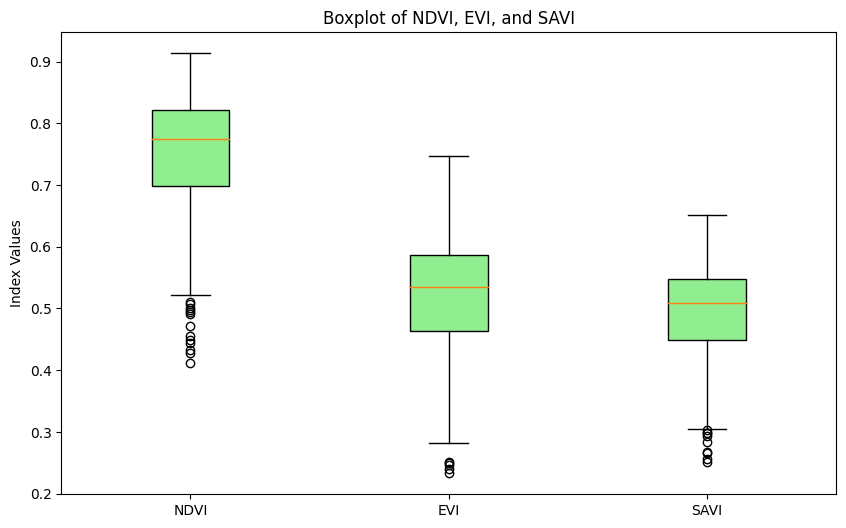

In [30]:
# Combine the values into a list for plotting
data = [ndvi_values, evi_values, savi_values]

# Plot the boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(data, patch_artist=True, boxprops=dict(facecolor='lightgreen'))

# Set x-axis labels
plt.xticks([1, 2, 3], ['NDVI', 'EVI', 'SAVI'])

# Add title and labels
plt.title('Boxplot of NDVI, EVI, and SAVI')
plt.ylabel('Index Values')

# Display the plot
plt.show()


Outliers found at indices: [19 29 39 48 61 73 74 85 90 93]


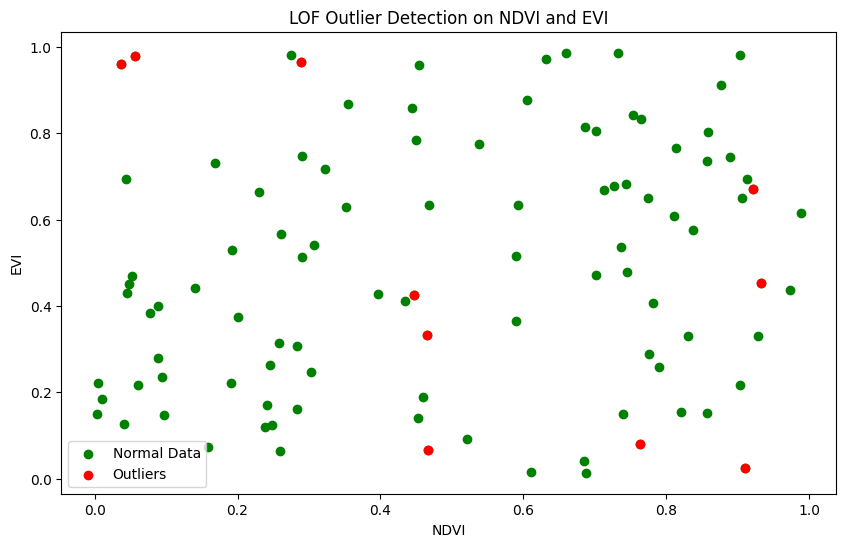

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# Sample data: NDVI, EVI, SAVI values (replace with your extracted data)
ndvi_values = np.random.random(100)  # Replace with actual ndvi_values
evi_values = np.random.random(100)   # Replace with actual evi_values
savi_values = np.random.random(100)  # Replace with actual savi_values

# Combine NDVI, EVI, SAVI into a single dataset (rows = samples, columns = features)
data = np.column_stack((ndvi_values, evi_values, savi_values))

# Initialize the LOF model (n_neighbors = 5 is typical)
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)

# Fit the model and predict outliers (-1 = outlier, 1 = inlier)
outlier_labels = lof.fit_predict(data)

# Find outliers
outlier_indices = np.where(outlier_labels == -1)[0]

print(f"Outliers found at indices: {outlier_indices}")

# Plot NDVI vs EVI with outliers highlighted
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], c='green', label='Normal Data')  # NDVI vs EVI
plt.scatter(data[outlier_indices, 0], data[outlier_indices, 1], c='red', label='Outliers')
plt.xlabel('NDVI')
plt.ylabel('EVI')
plt.title('LOF Outlier Detection on NDVI and EVI')
plt.legend()
plt.show()
